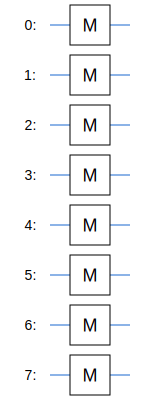

In [19]:
import sympy
import numpy as np
import cirq
import itertools
import math
from scipy.optimize import minimize
from tqdm import tqdm
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import json
from Parameters import *

L = len(qubits)

combinations=[]
for i in range(L):
    for j in range(L):
        if i!=j:
            combinations.append((i,j))
numcombinations=len(combinations)

def apply_hadamard():
        #Applies a Hadamard gate to all quibits
    hadamard=cirq.Circuit()
    for i in range(L):
        hadamard.append(cirq.H(qubits[i]))

    return hadamard

def apply_measurements():
    measurements=cirq.Circuit()
    for i in range(L):
        measurements.append(cirq.measure(qubits[i]))

    return measurements

def apply_QAOA_mixing_operator(beta):
    mixer=cirq.Circuit()
    for i in range(L):
        mixer.append(cirq.rx(2*beta).on(qubits[i]))
    circuit = cirq.Circuit(mixer)

    return circuit

def apply_risk_return(gamma):
    risk=cirq.Circuit()
    returns=cirq.Circuit()

    for i in range(numcombinations):
        q1=combinations[i][0]
        q2=combinations[i][1]
        ii=math.floor(q1/2)
        jj=math.floor(q2/2)
        sign=-(-1)**((q1 % 2)+(q2 %2))
        risk.append(cirq.ZZPowGate(exponent= 1/2*sign*gamma*lam*sigma[ii][jj]).on(qubits[q1],qubits[q2]))

    for i in range(L):
        returns.append(cirq.rz((-1)**int(i)*(1-lam)*gamma*mu[int(i/2)]).on(qubits[i]))

    circuit = cirq.Circuit((risk,returns))

    SVGCircuit(circuit)
    return circuit

def apply_soft_constraint(circuit,gamma):
  constraint=circuit
  for i in range(len(qubits)):
      sign=(-1)**i
      constraint.append(cirq.rz( sign *2 *gamma*A*D).on(qubits[i]))
  for i in range(numcombinations):
      q1=combinations[i][0]
      q2=combinations[i][1]
      sign=-(-1)**((q1 % 2)+(q2 %2))
      constraint.append(cirq.ZZPowGate(exponent= 1/2*sign*A*gamma).on(qubits[q1],qubits[q2]))

  return constraint


def QAOA_soft():
    gammas = sympy.symbols(["\u03B3_" + str(k) for k in range(p)])
    betas = sympy.symbols(["\u03B2_" + str(k) for k in range(p)])
    circuit = cirq.Circuit()
    circuit = apply_hadamard()

    for k in range(0,p):
            beta = betas[k]
            gamma = gammas[k]
            circuit = apply_QAOA_mixing_operator(beta)
            circuit = apply_risk_return(gamma)
            circuit = apply_soft_constraint(circuit,gamma)
            
    
    circuit = apply_measurements()

    return circuit

SVGCircuit(QAOA_soft())